In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px

In [2]:
# Import Data
retail = pd.read_csv('../data/cleaning_data.csv')

In [3]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledQuantity
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0


In [4]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392732 entries, 0 to 392731
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   InvoiceNo          392732 non-null  int64  
 1   StockCode          392732 non-null  object 
 2   Description        392732 non-null  object 
 3   Quantity           392732 non-null  int64  
 4   InvoiceDate        392732 non-null  object 
 5   UnitPrice          392732 non-null  float64
 6   CustomerID         392732 non-null  int64  
 7   Country            392732 non-null  object 
 8   CancelledQuantity  392732 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 27.0+ MB


In [5]:
retail.isnull().sum()

InvoiceNo            0
StockCode            0
Description          0
Quantity             0
InvoiceDate          0
UnitPrice            0
CustomerID           0
Country              0
CancelledQuantity    0
dtype: int64

### InvoiceNo and CanceeldQuantity

In [6]:
retail['InvoiceNo'].value_counts().shape

(18536,)

There are 22190 unique orders during this time peroid. As an order can be parially cancelled, I will use transaction to calculate the cancell rate.

If the 'cancelledQuantity' does not equal zero, it suggests that this transaction has either been cancelled in full or in part. Therefore, to simplify our understanding and processing of the data, I'm creating a new column called 'cancelled'. This column will clearly indicate whether a given transaction has been cancelled (fully or partially) or not.

In [7]:
retail['Cancelled'] = retail['CancelledQuantity'].apply(lambda x: 1 if x != 0 else 0)

retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledQuantity,Cancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0


In [8]:
tran_percentage = retail['Cancelled'].value_counts(normalize = True).reset_index()

tran_percentage

,index,Cancelled
0,0,0.981122
1,1,0.018878


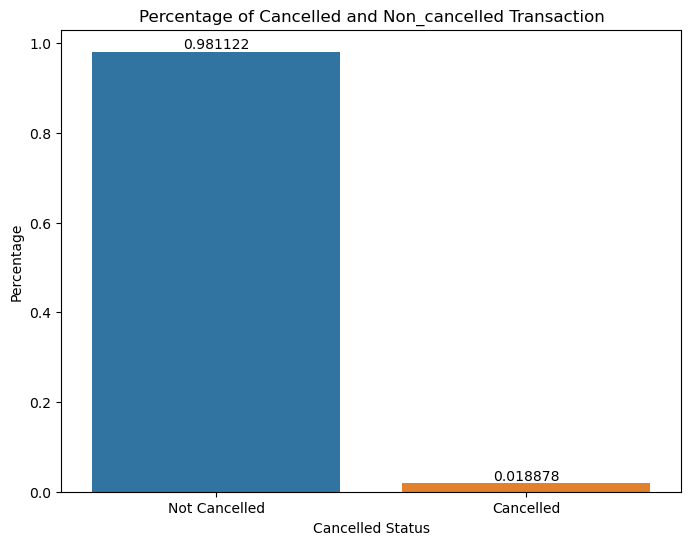

In [9]:
plt.figure(figsize = (8, 6))
ax = sns.barplot(x = 'index', y = 'Cancelled', data = tran_percentage)
ax.bar_label(ax.containers[0])
plt.title('Percentage of Cancelled and Non_cancelled Transaction')
plt.xlabel('Cancelled Status')
plt.ylabel('Percentage')
plt.xticks([0, 1], ['Not Cancelled', 'Cancelled']);

The rate of cancellations is approximately 1.8%, a figure that is considerably low.

### StockCode and Description

In [10]:
len(retail['StockCode'].unique())

3665

A total of 3665 unique items are sold during this peroid.

In [11]:
len(retail['Description'].unique())

3877

A total of 3877 unique description which is larger than 3665, It looks like some itmes are describe multiple times. Let's find these items.

In [12]:
retail_unique_code_des = retail[['StockCode', 'Description']].drop_duplicates()
retail_unique_code = retail_unique_code_des.groupby('StockCode').agg({'Description': 'count'}).reset_index()

In [13]:
retail_unique_code[retail_unique_code['Description'] > 1]

,StockCode,Description
42,16156L,2
100,17107D,3
118,20622,2
170,20725,2
262,20914,2
...,...,...
3293,85184C,2
3294,85185B,2
3357,90014A,2
3358,90014B,2


In [14]:
retail_des = retail_unique_code_des[retail_unique_code_des['StockCode'].isin(retail_unique_code[retail_unique_code['Description'] > 1]['StockCode'])].sort_values('StockCode')

In [15]:
retail_des

,StockCode,Description
28756,16156L,"WRAP, CAROUSEL"
90797,16156L,WRAP CAROUSEL
222513,17107D,FLOWER FAIRY 5 DRAWER LINERS
245537,17107D,FLOWER FAIRY 5 SUMMER DRAW LINERS
4197,17107D,"FLOWER FAIRY,5 SUMMER B'DRAW LINERS"
...,...,...
23385,90014A,SILVER/MOP ORBIT NECKLACE
17659,90014B,GOLD M PEARL ORBIT NECKLACE
276571,90014B,GOLD M.O.P. ORBIT NECKLACE
367711,90014C,SILVER AND BLACK ORBIT NECKLACE


It appears that for certain StockCodes, multiple descriptions are essentially conveying the same information, albeit using different phrasing. Therefore, to maintain consistency, I have decided to standardize these descriptions. I've accomplished this by aligning all descriptions for a given StockCode with the first observed description for that code.

In [16]:
mapping = {}

In [17]:
for code, description in zip(retail_des.drop_duplicates(subset = 'StockCode')['StockCode'], retail_des.drop_duplicates(subset = 'StockCode')['Description']):
    mapping[code] = description

In [18]:
for code in mapping:
    retail.loc[retail['StockCode'] == code, 'Description'] = mapping[code]

In [19]:
len(retail['StockCode'].unique()), len(retail['Description'].unique())

(3665, 3646)

In [20]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledQuantity,Cancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0


The current state of the data shows that the count of unique 'StockCode' values exceeds that of 'Description'. This suggests that there are instances where different items, indicated by unique stock codes, share the same description. This observation aligns with expectations, as it's quite plausible for distinct items to be categorized under a common description. Now, we can calculate and compare the most frequent items.

In [21]:
# List the most frequent items among the transactions, regardless of whether they are eventually cancelled
code_des_mapping = dict(zip(retail['StockCode'], retail['Description']))

retail_stock_freq = retail['StockCode'].value_counts().reset_index()

retail_stock_freq

,index,StockCode
0,85123A,2023
1,22423,1714
2,85099B,1615
3,84879,1395
4,47566,1390
...,...,...
3660,20678,1
3661,90059D,1
3662,90168,1
3663,90169,1


In [22]:
retail_stock_freq['index'] = retail_stock_freq['index'].replace(code_des_mapping)

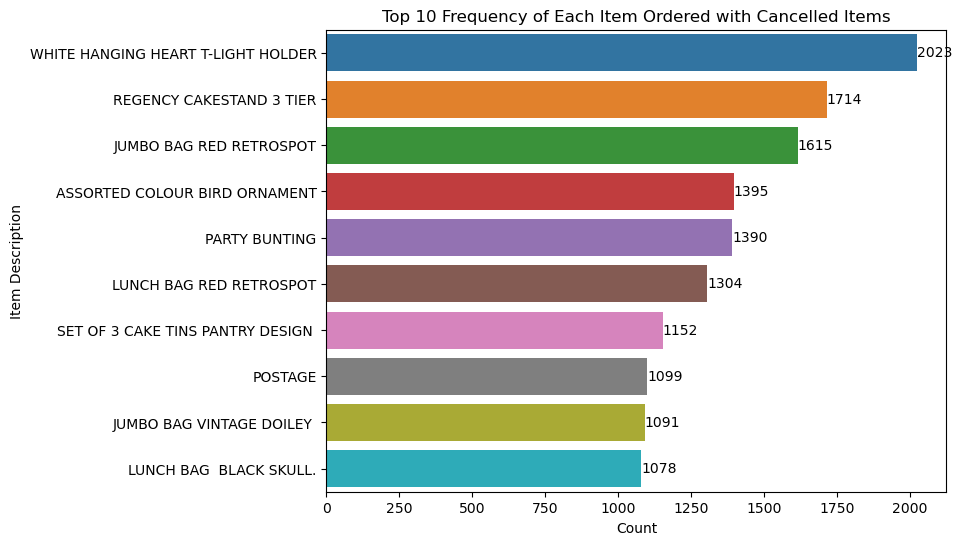

In [23]:
plt.figure(figsize = (8, 6))
ax = sns.barplot(y = 'index', x = 'StockCode', data = retail_stock_freq.head(10))
ax.bar_label(ax.containers[0])
plt.title('Top 10 Frequency of Each Item Ordered with Cancelled Items')
plt.xlabel('Count')
plt.ylabel('Item Description');

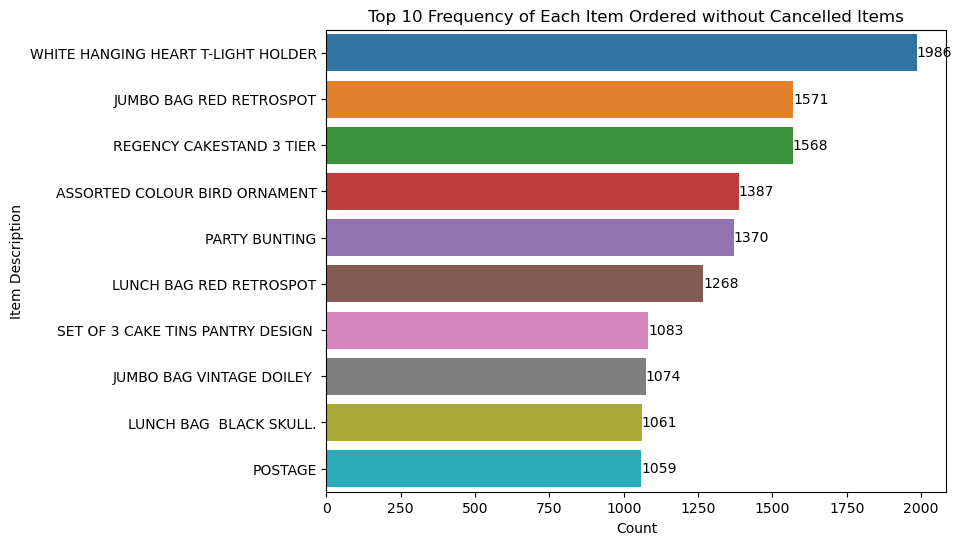

In [24]:
# List the most frequent items among the orders, fully processed and sold
retail_stock_freq = retail[retail['Cancelled'] == 0]['StockCode'].value_counts().reset_index()

retail_stock_freq['index'] = retail_stock_freq['index'].replace(code_des_mapping)

plt.figure(figsize = (8, 6))
ax = sns.barplot(y = 'index', x = 'StockCode', data = retail_stock_freq.head(10))
ax.bar_label(ax.containers[0])
plt.title('Top 10 Frequency of Each Item Ordered without Cancelled Items')
plt.xlabel('Count')
plt.ylabel('Item Description');

### CustomerID

In [25]:
len(retail['CustomerID'].unique())

4339

In total, there are 4,372 customers who have made purchases on the website and are registered.

Let's initially focus our attention on the customners who have placed the greatest number of orders.

In [26]:
retail_not_cancelled = retail[retail['Cancelled'] == 0]

retail_not_cancelled.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledQuantity,Cancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0


In [27]:
retail_unique_cus_inv = retail_not_cancelled[['CustomerID', 'InvoiceNo']].drop_duplicates()

In [28]:
retail_cus_freq = retail_unique_cus_inv.groupby('CustomerID').agg({'InvoiceNo': 'count'}).sort_values(by = 'InvoiceNo', ascending = False).reset_index()

retail_cus_freq['CustomerID']= retail_cus_freq['CustomerID'].astype('str')

retail_cus_freq

,CustomerID,InvoiceNo
0,12748,205
1,14911,198
2,17841,124
3,13089,93
4,14606,91
...,...,...
4318,13745,1
4319,13747,1
4320,16222,1
4321,13751,1


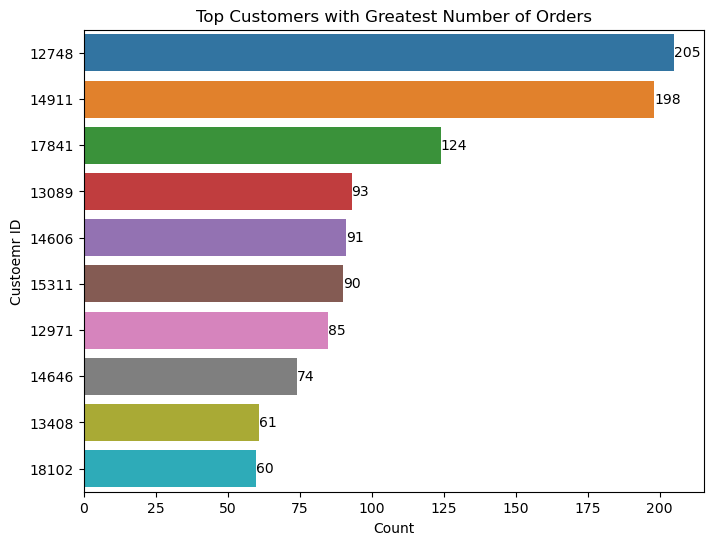

In [29]:
plt.figure(figsize = (8, 6))
ax = sns.barplot(y = 'CustomerID', x = 'InvoiceNo', data = retail_cus_freq.head(10))
ax.bar_label(ax.containers[0])
plt.title('Top Customers with Greatest Number of Transactions')
plt.xlabel('Count')
plt.ylabel('Custoemr ID');

The customer with the ID 12748 holds the record for placing the highest number of orders on our website. However, this is only considering the quantity of orders. Later on, we'll evaluate these customers on a qualitative basis as well, meaning we'll look at the total expenditure they've made on our website.

### Country

In [30]:
len(retail['Country'].unique())

37

In [31]:
retail['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Finland',
       'Austria', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Israel', 'Saudi Arabia', 'Czech Republic',
       'Canada', 'Unspecified', 'Brazil', 'USA', 'European Community',
       'Bahrain', 'Malta', 'RSA'], dtype=object)

Our customer base is quite diverse, spanning across 37 different Countries. Let's check the distribution of our customers.

In [32]:
retail_unique_ctr_cus = retail[['CustomerID', 'Country']].drop_duplicates()

retail_unique_ctr_cus

,CustomerID,Country
0,17850,United Kingdom
9,13047,United Kingdom
26,12583,France
46,13748,United Kingdom
65,15100,United Kingdom
...,...,...
389813,13436,United Kingdom
389885,15520,United Kingdom
390612,13298,United Kingdom
391328,14569,United Kingdom


In [33]:
retail_ctr_freq = retail_unique_ctr_cus.groupby('Country').agg({'CustomerID': 'count'}).sort_values('CustomerID', ascending = False).reset_index()

retail_ctr_freq.rename(columns = {'CustomerID': 'Customers'}, inplace = True)

retail_ctr_freq.head(10)

,Country,Customers
0,United Kingdom,3921
1,Germany,94
2,France,87
3,Spain,30
4,Belgium,25
5,Switzerland,21
6,Portugal,19
7,Italy,14
8,Finland,12
9,Austria,11


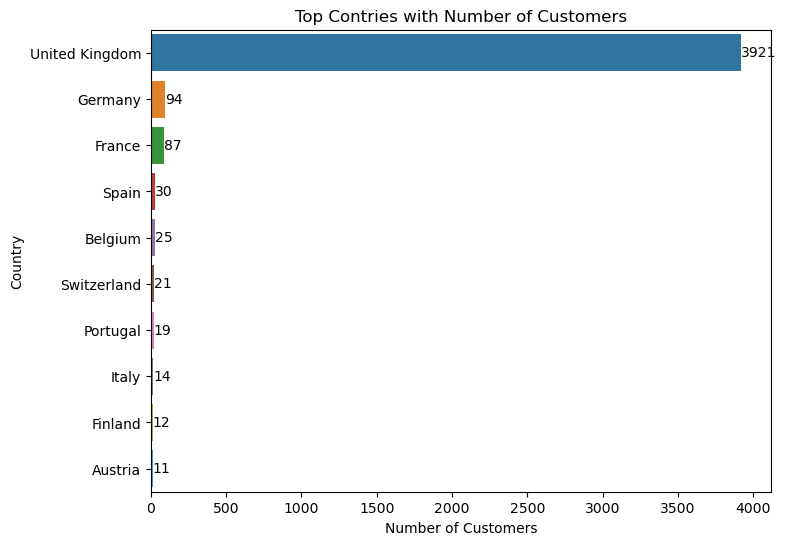

In [34]:
plt.figure(figsize = (8, 6))
ax = sns.barplot(y = 'Country', x = 'Customers', data = retail_ctr_freq.head(10))
ax.bar_label(ax.containers[0])
plt.title('Top Contries with Number of Customers')
plt.xlabel('Number of Customers')
plt.ylabel('Country');

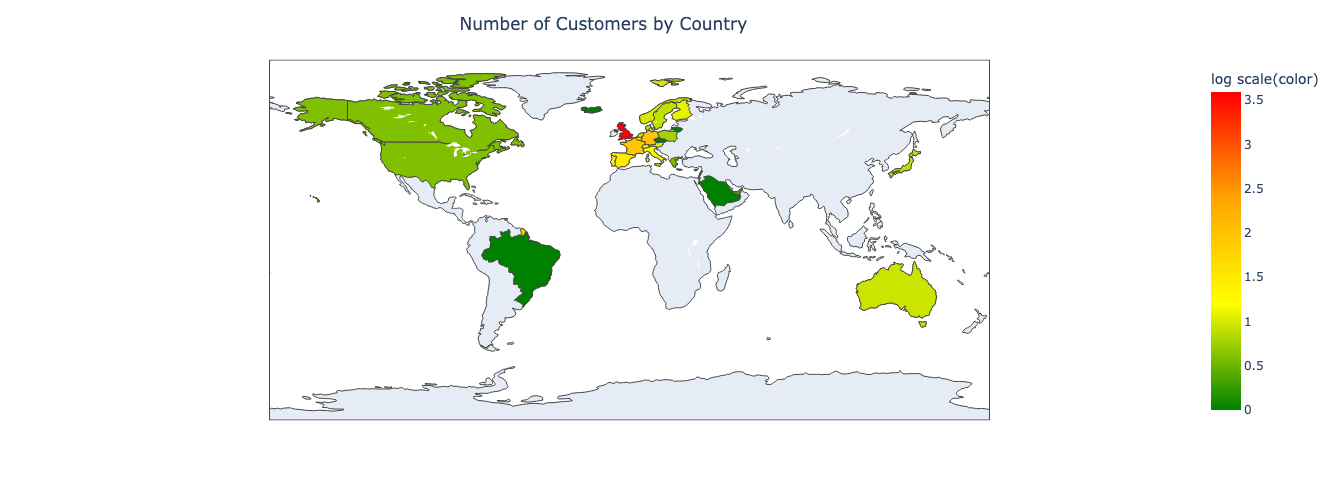

In [44]:
#Plotly function to make Geography graphs! Source from Lucas.
fig = px.choropleth(retail_ctr_freq, #DataFrame
                    locations = 'Country',
                    locationmode = 'country names', #Plotly's set location mode to usa states
                    color = np.log10(retail_ctr_freq['Customers']), #Color based
                    color_continuous_scale= ['green', 'yellow', 'orange' ,'red'], #Color scale from low to high frequency, Green is low and red is high
                    scope = 'world', 
                    hover_name='Country', 
                    hover_data={'Customers':True, 'Country': False},
                    width = 1000, #Size of graph
                    height = 500, #Size of graph
                    labels={'color':'log scale(color)'}
                    )
fig.update_layout(title_text='Number of Customers by Country', title_x=0.45)
fig.show()

The majority of our customers is from the United Kingdom, but we also have a significant number of customers in Germany and France.

In addition to analyzing the total number of customers from various countries, we can also explore which countries place the most orders.

In [46]:
retail_unique_ctr_inv = retail[retail['Cancelled'] == 0][['InvoiceNo', 'Country']].drop_duplicates()

retail_unique_ctr_inv

,InvoiceNo,Country
0,536365,United Kingdom
7,536366,United Kingdom
9,536367,United Kingdom
21,536368,United Kingdom
25,536369,United Kingdom
...,...,...
392688,581583,United Kingdom
392690,581584,United Kingdom
392692,581585,United Kingdom
392713,581586,United Kingdom


In [47]:
retail_ctr_inv_freq = retail_unique_ctr_inv.groupby('Country').agg({'InvoiceNo': 'count'}).sort_values('InvoiceNo', ascending = False).reset_index()

retail_ctr_inv_freq.rename(columns = {'InvoiceNo': 'Orders'}, inplace = True)

retail_ctr_inv_freq.head(10)

,Country,Orders
0,United Kingdom,16472
1,Germany,454
2,France,384
3,EIRE,257
4,Belgium,98
5,Netherlands,95
6,Spain,89
7,Australia,53
8,Portugal,51
9,Switzerland,50


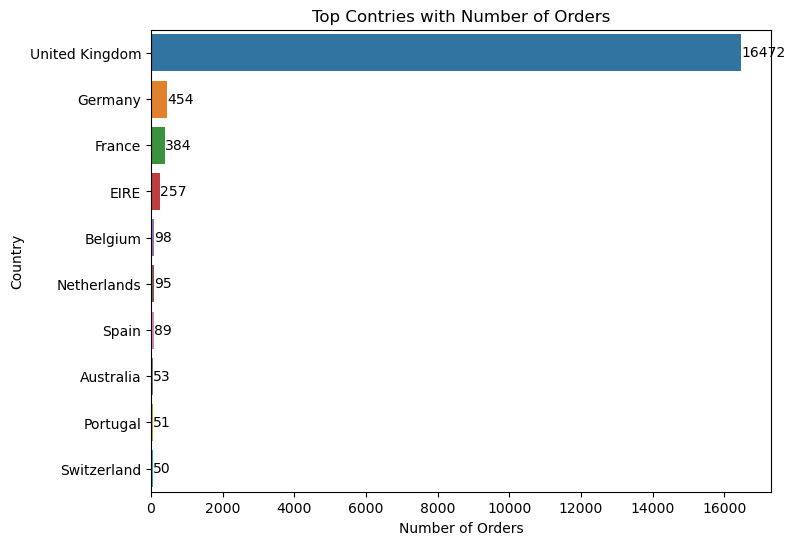

In [48]:
plt.figure(figsize = (8, 6))
ax = sns.barplot(y = 'Country', x = 'Orders', data = retail_ctr_inv_freq.head(10))
ax.bar_label(ax.containers[0])
plt.title('Top Contries with Number of Orders')
plt.xlabel('Number of Orders')
plt.ylabel('Country');

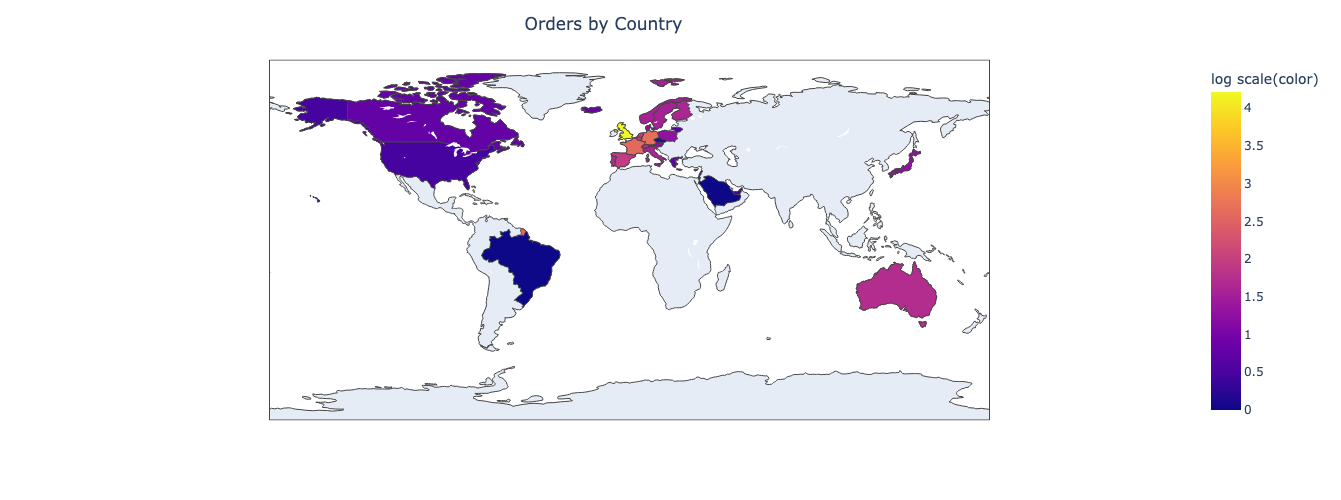

In [50]:
#Plotly function to make Geography graphs! Source from Lucas.
fig = px.choropleth(retail_ctr_inv_freq, #DataFrame
                    locations = 'Country',
                    locationmode = 'country names', #Plotly's set location mode to usa states
                    color= np.log10(retail_ctr_inv_freq['Orders']), #Color based off of frequency
                    # color_continuous_scale= ['green', 'yellow', 'orange' ,'red'], #Color scale from low to high frequency, Green is low and red is high
                    scope = 'world', 
                    width = 1000, #Size of graph
                    height = 500, #Size of graph
                    hover_name='Country', 
                    hover_data={'Orders':True, 'Country': False},
                    labels={'color':'log scale(color)'}
                    )
fig.update_layout(title_text='Orders by Country', title_x=0.45)

fig.show()

Unsurprisingly, the highest number of orders come from the United Kingdom, Germany, and France. This observation aligns with our earlier findings about the distribution of our customers, confirming that these countries constitute our primary markets.

### Sales (Quantity, UnitPrice and CancelledQuantity)

In the context of an e-commerce business, understanding sales dynamics is crucial. Consequently, I'll be examining our daily sales performance. To provide a comprehensive view, I'll consider both scenarios: including and excluding the cancelled orders. By comparing these two sets of data, we can gain insights into how cancellations impact our overall sales.

In [75]:
# Create a column 'Date' to show the date of each transaction.
retail['Date'] = pd.to_datetime(retail['InvoiceDate']).dt.date

retail['Date'] = pd.to_datetime(retail['Date'])

retail['Date'].dtypes

dtype('<M8[ns]')

In [76]:
retail.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledQuantity,Cancelled,Date,GrossSale,NetSale
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,0,2010-12-01,15.30,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0,2010-12-01,20.34,20.34


In [77]:
# Create two columns 'GrossSale' and 'NetSale' for each transaction
retail['GrossSale'] = retail['Quantity'] * retail['UnitPrice']
retail['NetSale'] = (retail['Quantity'] - retail['CancelledQuantity']) * retail['UnitPrice']

In [78]:
retail.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledQuantity,Cancelled,Date,GrossSale,NetSale
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,0,2010-12-01,15.30,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,0,2010-12-01,20.34,20.34


In [83]:
# Calculate day's gross sales and net sales
sales = retail.groupby('Date').agg({'GrossSale': 'sum', 'NetSale': 'sum'})

sales.head()

,GrossSale,NetSale
Date,,
2010-12-01,46192.49,45781.00
2010-12-02,47197.57,46689.40
2010-12-03,23876.63,23168.08
2010-12-05,31361.28,31065.79
2010-12-06,31009.33,30570.33


In [94]:
sales_week = sales.resample('W').sum()
sales_month = sales.resample('M').sum()

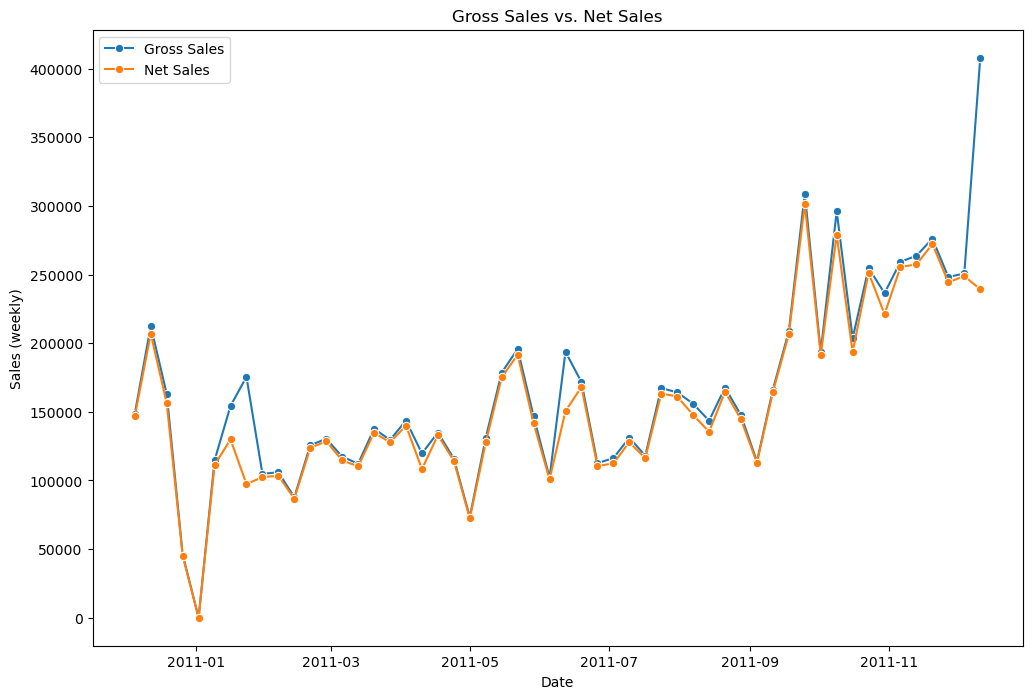

In [101]:
# Create a line chart to visualize how weekly sales trends change over time.
plt.figure(figsize = (12, 8))
sns.lineplot(x = sales_week.index, y = 'GrossSale', data = sales_week, label = 'Gross Sales', marker='o')
sns.lineplot(x = sales_week.index, y = 'NetSale', data = sales_week, label = 'Net Sales', marker = 'o')
plt.ylabel('Sales (weekly)')
plt.title('Gross Sales vs. Net Sales (Sterling)')
plt.legend();

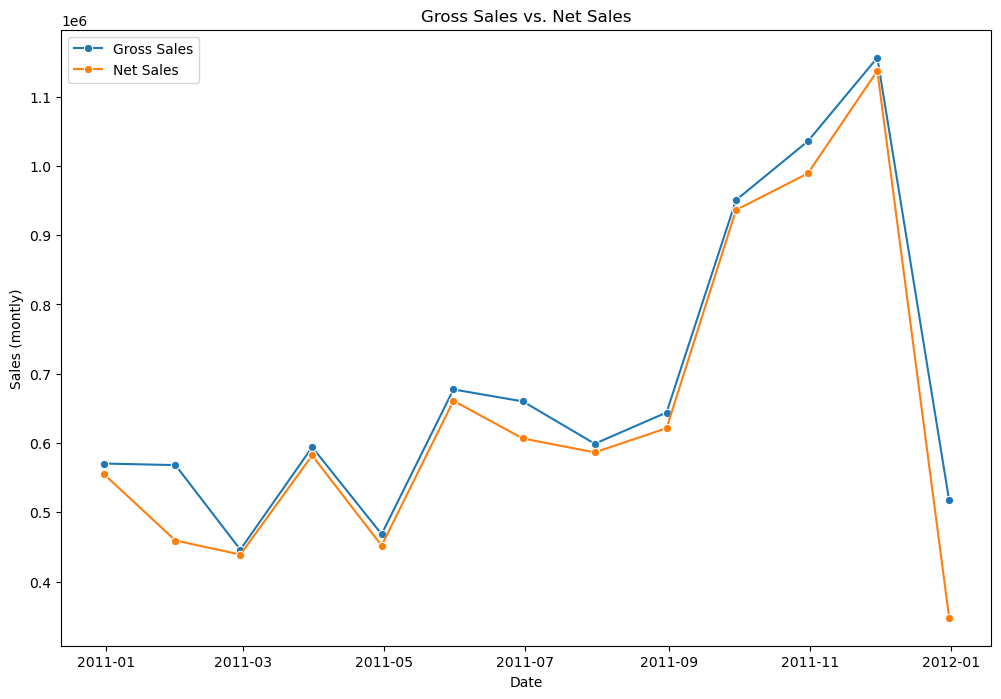

In [100]:
# Create a line chart to visualize how monthly sales trends change over time.
plt.figure(figsize = (12, 8))
sns.lineplot(x = sales_month.index, y = 'GrossSale', data = sales_month, label = 'Gross Sales', marker='o')
sns.lineplot(x = sales_month.index, y = 'NetSale', data = sales_month, label = 'Net Sales', marker='o')
plt.ylabel('Sales (montly)')
plt.title('Gross Sales vs. Net Sales (Sterling)')
plt.legend();

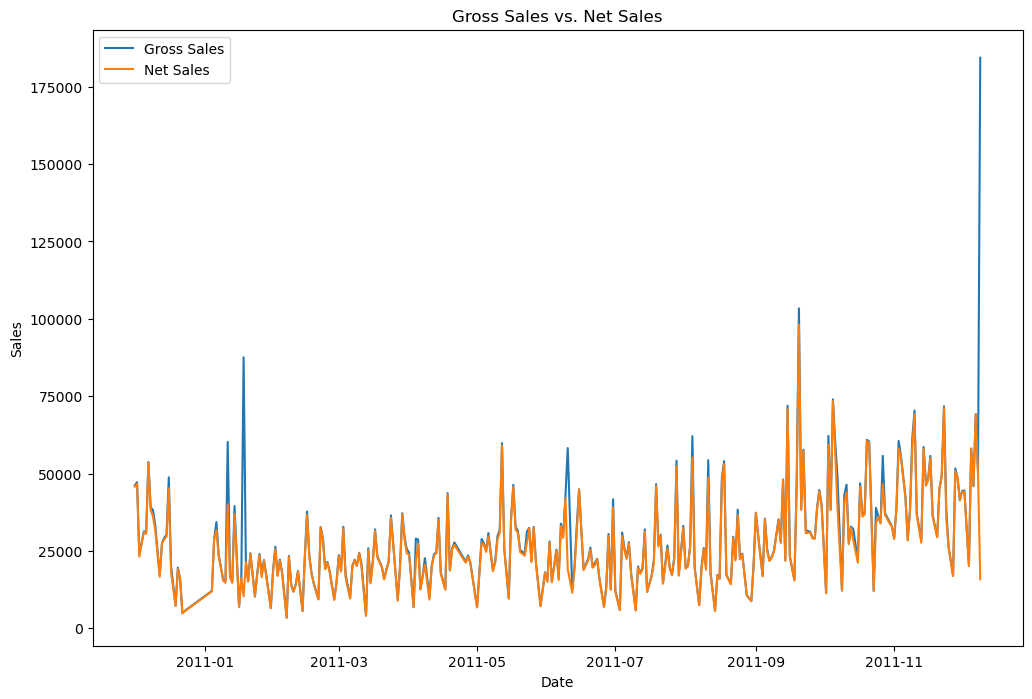

In [90]:
# Create a line chart to visualize how sales trends change over time.
plt.figure(figsize = (12, 8))
sns.lineplot(x = sales.index, y = 'GrossSale', data = sales, label = 'Gross Sales')
sns.lineplot(x = sales.index, y = 'NetSale', data = sales, label = 'Net Sales')
plt.ylabel('Sales')
plt.title('Gross Sales vs. Net Sales (Sterling)')
plt.legend();

In general, cancelled orders don't significantly impact overall sales. However, on certain days, they have a pronounced effect, causing a substantial decline in sales especially in the middle of January 2011 and towards the end of December 2011. Hence, it's crucial to examine the cancellation rate for each item and identify those that have a high rate of cancellation.

In [105]:
# Calcualte total "Quantity" and "Cancelled Quantity" for each item
retail_quantity = retail.groupby(by = ['StockCode', 'Description']).agg({'Quantity': 'sum', 'CancelledQuantity': 'sum'}).reset_index()

retail_quantity['Rates'] = retail_quantity['CancelledQuantity'] / retail_quantity['Quantity']

retail_quantity

,StockCode,Description,Quantity,CancelledQuantity,Rates
0,10002,INFLATABLE POLITICAL GLOBE,823,0,0.000000
1,10080,GROOVY CACTUS INFLATABLE,291,0,0.000000
2,10120,DOGGY RUBBER,192,0,0.000000
3,10123C,HEARTS WRAPPING TAPE,5,0,0.000000
4,10124A,SPOTS ON RED BOOKCOVER TAPE,16,0,0.000000
...,...,...,...,...,...
3660,C2,CARRIAGE,134,1,0.007463
3661,DOT,DOTCOM POSTAGE,16,0,0.000000
3662,M,Manual,6939,99,0.014267
3663,PADS,PADS TO MATCH ALL CUSHIONS,4,0,0.000000


In [113]:
retail_quantity[retail_quantity['Rates'] != 0].sort_values('Rates', ascending = False)

,StockCode,Description,Quantity,CancelledQuantity,Rates
2750,79323P,PINK CHERRY LIGHTS,4,4,1.000000
3548,90168,2 DAISIES HAIR COMB,6,6,1.000000
3565,90177E,DROP DIAMANTE EARRINGS GREEN,6,6,1.000000
3573,90182C,BLACK 3 BEAD DROP EARRINGS,6,6,1.000000
157,20703,BLUE PADDED SOFT MOBILE,1,1,1.000000
...,...,...,...,...,...
1079,22188,BLACK HEART CARD HOLDER,4843,1,0.000206
76,17003,BROCADE RING PURSE,22927,3,0.000131
2836,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,7892,1,0.000127
1415,22560,TRADITIONAL MODELLING CLAY,7990,1,0.000125


We have identified that 1786 unique items have a record of transactions being cancelled. Some of these items, despite having a small sales quantity, have all their transactions cancelled. Similarly, certain items with substantial sales volume exhibit high cancellation rates. In order to gain more insightful understanding, we will narrow down our analysis. Specifically, we will focus on items with a cancellation rate that is high either due to very low sales volume (10 or fewer units sold) or very high sales volume (more than 1000 units sold).

In [117]:
# The Item sold less than 10 but all cancelled
retail_quantity[(retail_quantity['Rates'] == 1) & (retail_quantity['Quantity'] <= 10)].sort_values('Rates', ascending = False)

,StockCode,Description,Quantity,CancelledQuantity,Rates
157,20703,BLUE PADDED SOFT MOBILE,1,1,1.0
700,21667,GLASS CAKE COVER AND PLATE,2,2,1.0
2750,79323P,PINK CHERRY LIGHTS,4,4,1.0
3423,90059A,DIAMANTE HAIR GRIP PACK/2 CRYSTAL,6,6,1.0
3426,90059D,DIAMANTE HAIR GRIP PACK/2 PERIDOT,6,6,1.0
3472,90118,PINK DAISY BAG CHARM,6,6,1.0
3548,90168,2 DAISIES HAIR COMB,6,6,1.0
3549,90169,DAISY HAIR COMB,6,6,1.0
3561,90177A,CLASSIC DIAMANTE EARRINGS JET,6,6,1.0
3565,90177E,DROP DIAMANTE EARRINGS GREEN,6,6,1.0


The twelve items identified have all been sold in quantities less than 10 units and all transactions were subsequently cancelled. It is recommended to consider discontinuing the sale of these stocks.

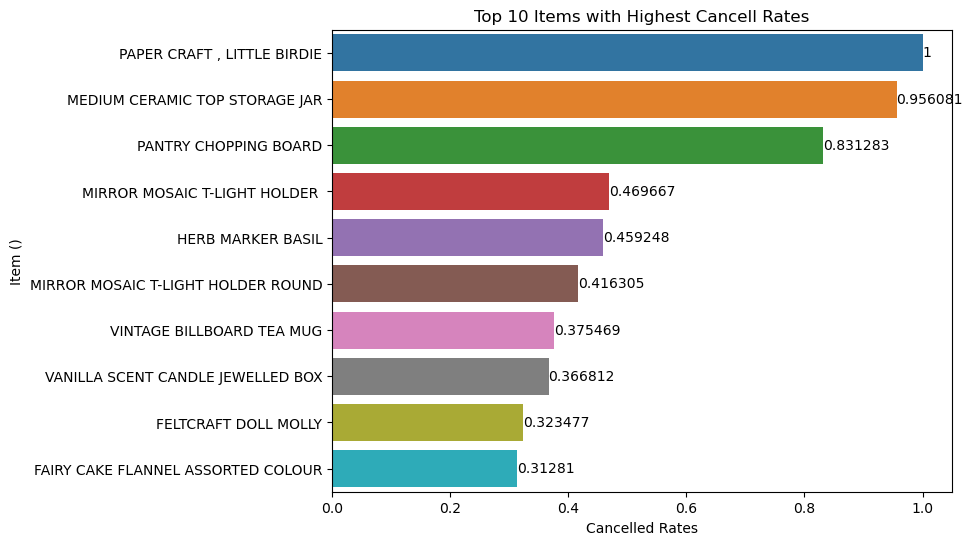

In [118]:
# List the items wiht high cancelled rates (quantity over 1000)
plt.figure(figsize = (8, 6))
ax = sns.barplot(y = 'Description', x = 'Rates', data = retail_quantity[retail_quantity['Quantity'] >= 1000].sort_values('Rates', ascending = False).head(10))
ax.bar_label(ax.containers[0])
plt.title('Top 10 Items with Highest Cancell Rates')
plt.xlabel('Cancelled Rates')
plt.ylabel('Item ()');

These items generate a significant volume of transactions, yet they also have high cancellation rates. It is therefore recommended that the respective department inspect the quality of these items to identify potential reasons behind this occurrence.

Furthermore, it is crucial to investigate if there are any customers who may be maliciously cancelling their orders.

In [125]:
# Find customerID who cancelled all of their transactions
retail_cus = retail.groupby('CustomerID').agg({'GrossSale': 'sum', 'NetSale': 'sum'}).reset_index()

retail_cus[retail_cus['GrossSale'] == retail_cus['NetSale']]

,CustomerID,GrossSale,NetSale
1,12347,4310.00,4310.00
2,12348,1797.24,1797.24
3,12349,1757.55,1757.55
4,12350,334.40,334.40
6,12353,89.00,89.00
...,...,...,...
4333,18278,173.90,173.90
4334,18280,180.60,180.60
4335,18281,80.82,80.82
4337,18283,2045.53,2045.53


Over 2891 customers have a history of cancellations, implying that cancellations are a frequent occurrence on this wholesale website. Therefore, our analysis should focus on those customers who have made over large number of transactions, all of which have been cancelled.

In [141]:
customers_large_tran = retail['CustomerID'].value_counts()[retail['CustomerID'].value_counts() > 2000].index

In [142]:
retail_cus[retail_cus['CustomerID'].isin(customers_large_tran)]

,CustomerID,GrossSale,NetSale
326,12748,33053.19,31304.15
1290,14096,65164.79,65164.79
1662,14606,12076.15,11797.21
1690,14646,280206.02,279765.02
1880,14911,143711.17,136445.40
2177,15311,60632.75,59340.33
4011,17841,40519.84,39920.11


It is recommended to check the order history of these customers as in this year they ordered more than 2000 transactions but all cancelled.

Finally, Let's take a look at the net sales for each country.

In [148]:
retail_ctr_net = retail.groupby('Country').agg({'NetSale': 'sum'}).sort_values('NetSale', ascending = False).reset_index()

retail_ctr_net.head(10)

,Country,NetSale
0,United Kingdom,6824029.894
1,Netherlands,284937.540
2,EIRE,255117.220
3,Germany,222626.940
4,France,196833.690
5,Australia,136950.250
6,Spain,57616.900
7,Switzerland,55751.400
8,Belgium,40891.040
9,Sweden,37773.410


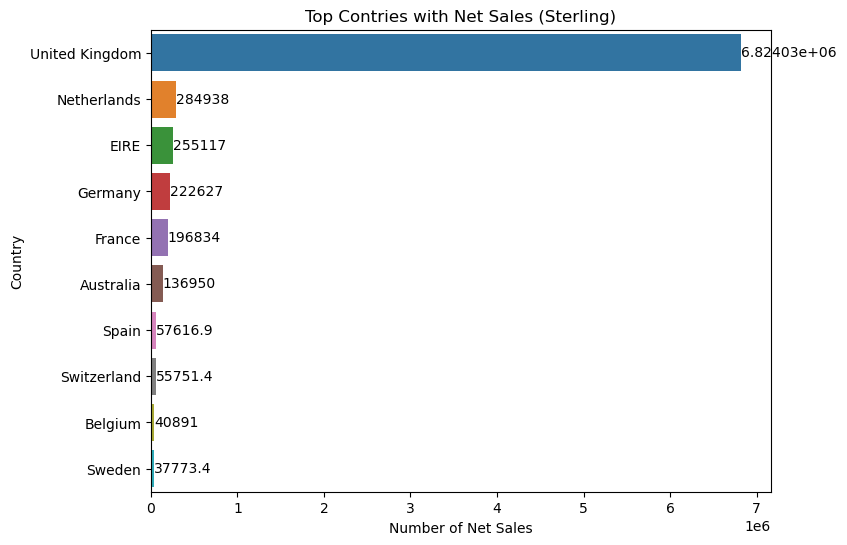

In [151]:
plt.figure(figsize = (8, 6))
ax = sns.barplot(y = 'Country', x = 'NetSale', data = retail_ctr_net.head(10))
ax.bar_label(ax.containers[0])
plt.title('Top Contries with Net Sales (Sterling)')
plt.xlabel('Number of Net Sales')
plt.ylabel('Country');

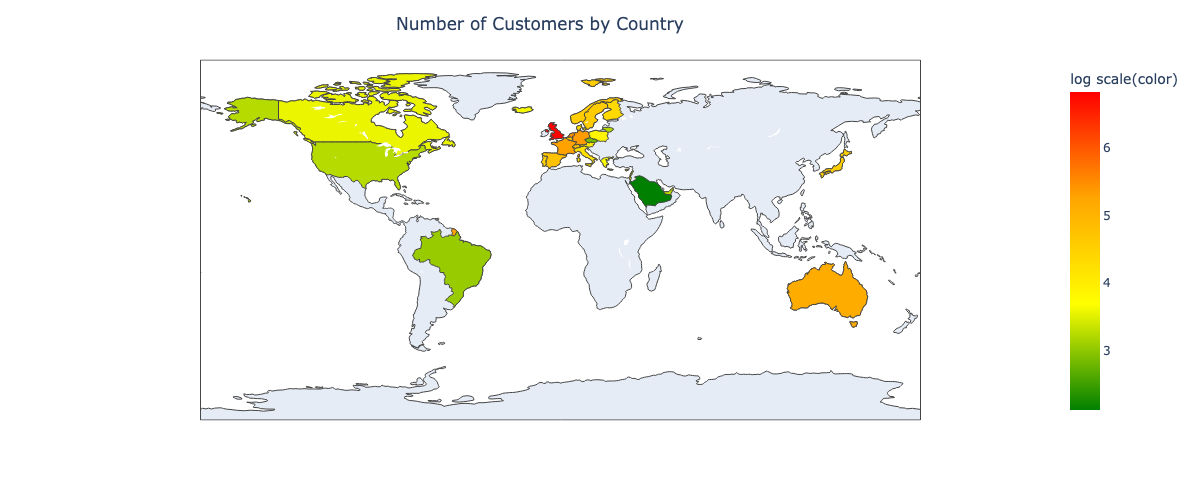

In [152]:
#Plotly function to make Geography graphs! Source from Lucas.
fig = px.choropleth(retail_ctr_net, #DataFrame
                    locations = 'Country',
                    locationmode = 'country names', #Plotly's set location mode to usa states
                    color = np.log10(retail_ctr_net['NetSale']), #Color based
                    color_continuous_scale= ['green', 'yellow', 'orange' ,'red'], #Color scale from low to high frequency, Green is low and red is high
                    scope = 'world', 
                    hover_name='Country', 
                    hover_data={'NetSale':True, 'Country': False},
                    width = 1000, #Size of graph
                    height = 500, #Size of graph
                    labels={'color':'log scale(color)'}
                    )
fig.update_layout(title_text='Number of Customers by Country', title_x=0.45)
fig.show()

The net sales are primarily from United Kindom, Netherlands and EIRE.